In [2]:
# Install required libraries
!pip install huggingface_hub requests pandas

# Import libraries
from huggingface_hub import HfApi, ModelCard
import pandas as pd
import requests
from typing import List, Dict
import time

print("Libraries installed and imported successfully!")


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


/Users/faiaz/Desktop/Policy Hacks/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries installed and imported successfully!


In [3]:
# Option 1: Recent models with high engagement (likes)
# This gets models that are both recent and community-validated

print("Fetching recent, highly-engaged models from Hugging Face...")

models = api.list_models(
    sort="likes",  # or "trending" 
    direction=-1,
    limit=100
)

# Convert to list with more detailed info
model_list = []
for model in models:
    model_list.append({
        'model_id': model.id,
        'downloads': model.downloads if hasattr(model, 'downloads') else 0,
        'likes': model.likes if hasattr(model, 'likes') else 0,
        'tags': model.tags if hasattr(model, 'tags') else [],
        'created_at': model.created_at if hasattr(model, 'created_at') else None,
        'last_modified': model.last_modified if hasattr(model, 'last_modified') else None
    })

df_models = pd.DataFrame(model_list)

print(f"Fetched {len(df_models)} models")
print("\nTop 10 models by likes:")
print(df_models.head(10)[['model_id', 'likes', 'downloads']])

Fetching recent, highly-engaged models from Hugging Face...


NameError: name 'api' is not defined

In [4]:
# Fetch model cards for the top 100 models
print("Fetching model cards...")

model_cards_data = []

for idx, row in df_models.iterrows():
    model_id = row['model_id']
    
    try:
        # Fetch the model card
        card = ModelCard.load(model_id)
        
        model_cards_data.append({
            'model_id': model_id,
            'card_text': card.text,  # Raw markdown text
            'card_data': card.data.to_dict() if card.data else {},  # Structured metadata
            'downloads': row['downloads'],
            'likes': row['likes'],
            'has_card': True
        })
        
        if (idx + 1) % 10 == 0:
            print(f"Fetched {idx + 1}/{len(df_models)} model cards...")
            
    except Exception as e:
        # Some models might not have cards or might error
        model_cards_data.append({
            'model_id': model_id,
            'card_text': None,
            'card_data': {},
            'downloads': row['downloads'],
            'likes': row['likes'],
            'has_card': False,
            'error': str(e)
        })
        
    # Small delay to avoid rate limiting
    time.sleep(0.1)

# Create DataFrame with model cards
df_cards = pd.DataFrame(model_cards_data)

print(f"\nSuccessfully fetched {df_cards['has_card'].sum()} model cards out of {len(df_cards)}")
print(f"Models without cards: {(~df_cards['has_card']).sum()}")

Fetching model cards...


NameError: name 'df_models' is not defined

In [11]:
import pickle
import json

# Save as pickle (preserves all data structures)
df_cards.to_pickle('huggingface_model_cards.pkl')
print("Saved as pickle file: huggingface_model_cards.pkl")

# Also save as JSON for easier inspection
# Convert to JSON-serializable format
cards_json = []
for idx, row in df_cards.iterrows():
    cards_json.append({
        'model_id': row['model_id'],
        'card_text': row['card_text'],
        'card_data': row['card_data'],
        'downloads': int(row['downloads']) if row['downloads'] else 0,
        'likes': int(row['likes']) if row['likes'] else 0,
        'has_card': bool(row['has_card'])
    })

with open('huggingface_model_cards.json', 'w', encoding='utf-8') as f:
    json.dump(cards_json, f, indent=2, ensure_ascii=False)
    
print("Saved as JSON file: huggingface_model_cards.json")

# Print summary
print(f"\nSaved {len(df_cards)} model cards")
print(f"Total size of card text: {sum(len(str(c)) for c in df_cards['card_text'] if c)} characters")

Saved as pickle file: huggingface_model_cards.pkl
Saved as JSON file: huggingface_model_cards.json

Saved 100 model cards
Total size of card text: 1231195 characters


In [ ]:
! pip install seaborn matplotlib

In [15]:
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved data
df_cards = pd.read_pickle('huggingface_model_cards.pkl')

# Filter to only cards that exist
df_with_cards = df_cards[df_cards['has_card']].copy()

print(f"Analyzing {len(df_with_cards)} model cards\n")

# Function to extract markdown sections (headers)
def extract_sections(card_text):
    if not card_text:
        return []
    
    # Find all markdown headers (# Header, ## Header, ### Header, etc.)
    # Pattern matches headers at different levels
    pattern = r'^(#{1,6})\s+(.+)$'
    sections = []
    
    for line in card_text.split('\n'):
        match = re.match(pattern, line.strip())
        if match:
            level = len(match.group(1))  # Number of # symbols
            title = match.group(2).strip()
            sections.append({
                'level': level,
                'title': title,
                'title_lower': title.lower()
            })
    
    return sections

# Extract sections from all cards
print("Extracting sections from model cards...")
df_with_cards['sections'] = df_with_cards['card_text'].apply(extract_sections)
df_with_cards['num_sections'] = df_with_cards['sections'].apply(len)

print(f"\nSection count statistics:")
print(df_with_cards['num_sections'].describe())
print(f"\nModels with no sections: {(df_with_cards['num_sections'] == 0).sum()}")

Analyzing 100 model cards

Extracting sections from model cards...

Section count statistics:
count    100.000000
mean      16.530000
std       12.555698
min        0.000000
25%        8.000000
50%       14.500000
75%       20.250000
max       68.000000
Name: num_sections, dtype: float64

Models with no sections: 3


In [16]:
# Collect all section titles across all cards
all_sections = []
section_by_model = defaultdict(list)

for idx, row in df_with_cards.iterrows():
    model_id = row['model_id']
    for section in row['sections']:
        # Store normalized (lowercase) title for comparison
        all_sections.append(section['title_lower'])
        section_by_model[model_id].append(section['title_lower'])

# Count frequency of each section title
section_counter = Counter(all_sections)

print("Top 30 most common sections across all model cards:\n")
for section, count in section_counter.most_common(30):
    percentage = (count / len(df_with_cards)) * 100
    print(f"{section:50s} | {count:3d} cards ({percentage:.1f}%)")

print(f"\nTotal unique section names: {len(section_counter)}")

Top 30 most common sections across all model cards:

training data                                      |  22 cards (22.0%)
usage                                              |  21 cards (21.0%)
citation                                           |  21 cards (21.0%)
limitations                                        |  19 cards (19.0%)
model details                                      |  18 cards (18.0%)
intended use                                       |  17 cards (17.0%)
license                                            |  15 cards (15.0%)
how to use                                         |  14 cards (14.0%)
model description                                  |  13 cards (13.0%)
hardware and software                              |  12 cards (12.0%)
ethical considerations and limitations             |  12 cards (12.0%)
evaluation results                                 |  11 cards (11.0%)
out-of-scope use                                   |  10 cards (10.0%)
evaluation              

In [17]:
# Group similar section names to find variations
# We'll use fuzzy matching to find sections that are semantically similar

from difflib import SequenceMatcher

def similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

# Define key concepts we expect to see in model cards
key_concepts = {
    'training': ['train', 'pretrain', 'fine-tun', 'dataset', 'data'],
    'evaluation': ['eval', 'benchmark', 'performance', 'metrics', 'results', 'test'],
    'limitations': ['limit', 'bias', 'ethical', 'risk', 'concern', 'issue'],
    'usage': ['use', 'usage', 'how to', 'application', 'implement'],
    'model_info': ['model detail', 'model description', 'model summary', 'model information', 'architecture'],
    'safety': ['safe', 'responsible', 'harm', 'guardrail'],
    'license': ['licen', 'copyright', 'terms'],
    'citation': ['cite', 'citation', 'bibtex', 'reference'],
    'intended_use': ['intended use', 'direct use', 'downstream', 'out-of-scope']
}

# Categorize sections by concept
categorized_sections = defaultdict(lambda: defaultdict(int))

for section in all_sections:
    categorized = False
    for concept, keywords in key_concepts.items():
        if any(keyword in section for keyword in keywords):
            categorized_sections[concept][section] += 1
            categorized = True
            break
    if not categorized:
        categorized_sections['other'][section] += 1

# Display categorized sections
print("Section naming variations by concept:\n")
for concept, sections in sorted(categorized_sections.items()):
    if concept == 'other':
        continue
    print(f"\n{concept.upper().replace('_', ' ')} ({sum(sections.values())} total mentions):")
    for section, count in sorted(sections.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {section:50s} | {count}")

print(f"\n\nOTHER/UNCATEGORIZED: {sum(categorized_sections['other'].values())} sections")

Section naming variations by concept:


CITATION (43 total mentions):
  citation                                           | 21
  bibtex entry and citation info                     | 5
  8. citation                                        | 3
  citation instructions                              | 2
  bibtex                                             | 2
  reference                                          | 1
  5. citation                                        | 1
  6. citation                                        | 1
  cite our work                                      | 1
  references(s):                                     | 1

EVALUATION (106 total mentions):
  evaluation results                                 | 11
  evaluation                                         | 10
  evaluations                                        | 7
  benchmarks                                         | 5
  performance and limitations                        | 4
  multilingual benchmarks             


Saved visualization as 'structural_consistency_analysis.png'


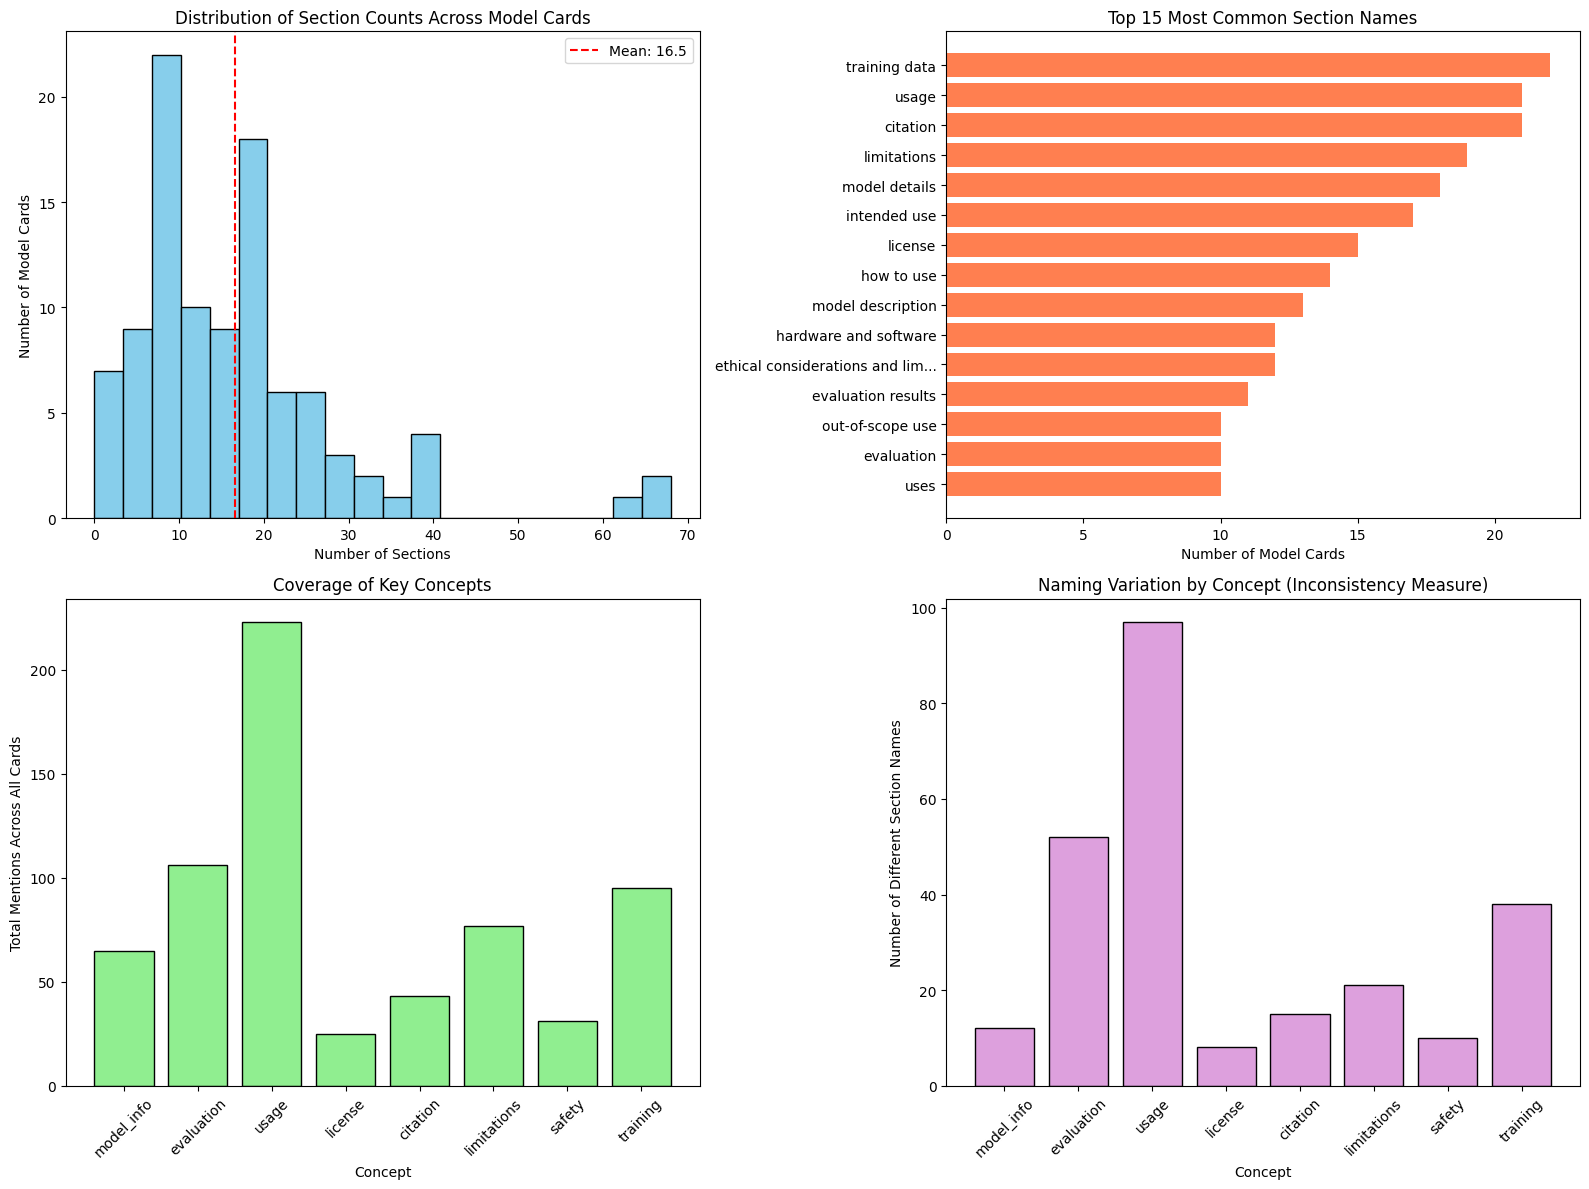


STRUCTURAL CONSISTENCY SUMMARY
Total model cards analyzed: 100
Total unique section names: 947
Average sections per card: 16.5
Cards with 0 sections: 3

Most consistent section: 'training data' (in 22% of cards)
Concept with most naming variations: ('usage', 97)


In [18]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of number of sections per card
axes[0, 0].hist(df_with_cards['num_sections'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Number of Sections')
axes[0, 0].set_ylabel('Number of Model Cards')
axes[0, 0].set_title('Distribution of Section Counts Across Model Cards')
axes[0, 0].axvline(df_with_cards['num_sections'].mean(), color='red', linestyle='--', label=f'Mean: {df_with_cards["num_sections"].mean():.1f}')
axes[0, 0].legend()

# 2. Top sections frequency
top_sections = section_counter.most_common(15)
sections_names = [s[0][:30] + '...' if len(s[0]) > 30 else s[0] for s in top_sections]
sections_counts = [s[1] for s in top_sections]

axes[0, 1].barh(sections_names, sections_counts, color='coral')
axes[0, 1].set_xlabel('Number of Model Cards')
axes[0, 1].set_title('Top 15 Most Common Section Names')
axes[0, 1].invert_yaxis()

# 3. Concept coverage across cards
concept_totals = {k: sum(v.values()) for k, v in categorized_sections.items() if k != 'other'}
concepts = list(concept_totals.keys())
counts = list(concept_totals.values())

axes[1, 0].bar(concepts, counts, color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('Concept')
axes[1, 0].set_ylabel('Total Mentions Across All Cards')
axes[1, 0].set_title('Coverage of Key Concepts')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Naming variations per concept
concept_variation_counts = {k: len(v) for k, v in categorized_sections.items() if k != 'other'}
concepts_var = list(concept_variation_counts.keys())
variations = list(concept_variation_counts.values())

axes[1, 1].bar(concepts_var, variations, color='plum', edgecolor='black')
axes[1, 1].set_xlabel('Concept')
axes[1, 1].set_ylabel('Number of Different Section Names')
axes[1, 1].set_title('Naming Variation by Concept (Inconsistency Measure)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('structural_consistency_analysis.png', dpi=300, bbox_inches='tight')
print("\nSaved visualization as 'structural_consistency_analysis.png'")
plt.show()

# Summary statistics
print("\n" + "="*70)
print("STRUCTURAL CONSISTENCY SUMMARY")
print("="*70)
print(f"Total model cards analyzed: {len(df_with_cards)}")
print(f"Total unique section names: {len(section_counter)}")
print(f"Average sections per card: {df_with_cards['num_sections'].mean():.1f}")
print(f"Cards with 0 sections: {(df_with_cards['num_sections'] == 0).sum()}")
print(f"\nMost consistent section: '{section_counter.most_common(1)[0][0]}' (in {section_counter.most_common(1)[0][1]}% of cards)")
print(f"Concept with most naming variations: {max(concept_variation_counts.items(), key=lambda x: x[1])}")

In [19]:
# Define critical information categories based on the challenge document
# and common AI documentation frameworks

critical_info_categories = {
    'training_data': {
        'keywords': ['training data', 'dataset', 'data source', 'training corpus', 'pretraining data', 'data collection', 'data composition'],
        'description': 'Information about training data sources and composition'
    },
    'model_architecture': {
        'keywords': ['architecture', 'parameters', 'layers', 'model size', 'billion parameters', 'transformer', 'attention'],
        'description': 'Technical details about model architecture'
    },
    'evaluation_metrics': {
        'keywords': ['evaluation', 'benchmark', 'accuracy', 'performance', 'metric', 'score', 'test', 'mmlu', 'hellaswag'],
        'description': 'Evaluation results and benchmarks'
    },
    'bias_fairness': {
        'keywords': ['bias', 'fairness', 'demographic', 'gender', 'race', 'toxicity', 'stereotype'],
        'description': 'Bias and fairness testing'
    },
    'safety_evaluation': {
        'keywords': ['safety', 'red team', 'adversarial', 'harmful', 'jailbreak', 'guardrail', 'refusal'],
        'description': 'Safety evaluations and red teaming'
    },
    'limitations': {
        'keywords': ['limitation', 'weakness', 'failure mode', 'does not', 'cannot', 'risk'],
        'description': 'Model limitations and failure modes'
    },
    'intended_use': {
        'keywords': ['intended use', 'use case', 'application', 'purpose', 'designed for'],
        'description': 'Intended use cases'
    },
    'out_of_scope': {
        'keywords': ['out-of-scope', 'out of scope', 'misuse', 'not intended', 'should not'],
        'description': 'Out-of-scope uses'
    },
    'compute_requirements': {
        'keywords': ['compute', 'gpu', 'hardware', 'memory', 'inference', 'training time', 'flops'],
        'description': 'Compute and hardware requirements'
    },
    'license': {
        'keywords': ['license', 'licence', 'terms', 'agreement', 'copyright'],
        'description': 'Licensing information'
    },
    'interpretability': {
        'keywords': ['interpretability', 'explainability', 'transparency', 'attention visualization', 'activation'],
        'description': 'Interpretability methods or explanations'
    }
}

# Check presence of each category in each model card
def check_info_presence(card_text, keywords):
    if not card_text:
        return False
    card_lower = card_text.lower()
    return any(keyword in card_lower for keyword in keywords)

print("Analyzing content completeness...\n")

# Create a matrix of what information each card contains
info_matrix = []
for idx, row in df_with_cards.iterrows():
    card_info = {'model_id': row['model_id']}
    for category, details in critical_info_categories.items():
        card_info[category] = check_info_presence(row['card_text'], details['keywords'])
    info_matrix.append(card_info)

df_info = pd.DataFrame(info_matrix)

# Calculate presence statistics
presence_stats = {}
for category in critical_info_categories.keys():
    count = df_info[category].sum()
    percentage = (count / len(df_info)) * 100
    presence_stats[category] = {
        'count': count,
        'percentage': percentage,
        'description': critical_info_categories[category]['description']
    }

# Sort by presence
sorted_stats = sorted(presence_stats.items(), key=lambda x: x[1]['percentage'], reverse=True)

print("="*80)
print("CONTENT COMPLETENESS ANALYSIS")
print("="*80)
print(f"{'Category':<25} | {'Present':<8} | {'%':<6} | Description")
print("-"*80)
for category, stats in sorted_stats:
    print(f"{category:<25} | {stats['count']:>3}/{len(df_info):<3} | {stats['percentage']:>5.1f}% | {stats['description']}")

Analyzing content completeness...

CONTENT COMPLETENESS ANALYSIS
Category                  | Present  | %      | Description
--------------------------------------------------------------------------------
model_architecture        |  84/100 |  84.0% | Technical details about model architecture
evaluation_metrics        |  84/100 |  84.0% | Evaluation results and benchmarks
compute_requirements      |  84/100 |  84.0% | Compute and hardware requirements
intended_use              |  65/100 |  65.0% | Intended use cases
license                   |  65/100 |  65.0% | Licensing information
limitations               |  61/100 |  61.0% | Model limitations and failure modes
training_data             |  60/100 |  60.0% | Information about training data sources and composition
bias_fairness             |  54/100 |  54.0% | Bias and fairness testing
safety_evaluation         |  52/100 |  52.0% | Safety evaluations and red teaming
out_of_scope              |  49/100 |  49.0% | Out-of-scope uses
i

Saved visualization as 'content_completeness_analysis.png'



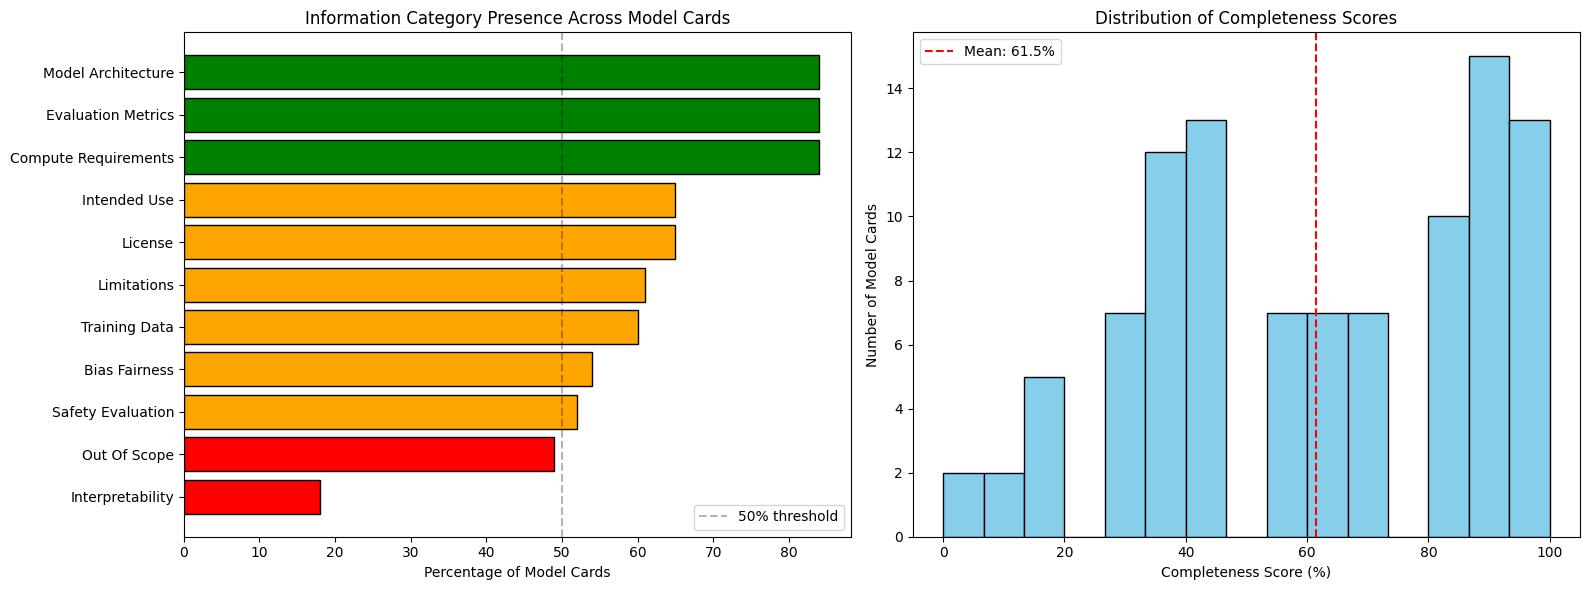

COMPLETENESS SCORE STATISTICS
Mean completeness: 61.5%
Median completeness: 63.6%
Std dev: 28.3%

Top 5 most complete model cards:
  meta-llama/Meta-Llama-3-8B                                   | 100.0%
  meta-llama/Llama-3.1-8B-Instruct                             | 100.0%
  meta-llama/Meta-Llama-3-8B-Instruct                          | 100.0%
  google/gemma-7b                                              | 100.0%
  meta-llama/Llama-3.3-70B-Instruct                            | 100.0%

Bottom 5 least complete model cards:
  lllyasviel/ControlNet-v1-1                                   | 0.0%
  lllyasviel/sd_control_collection                             | 0.0%
  prompthero/openjourney                                       | 9.1%
  gsdf/Counterfeit-V2.5                                        | 9.1%
  lllyasviel/ControlNet                                        | 18.2%


In [20]:
# Visualize completeness
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Category presence bar chart
categories = [s[0].replace('_', ' ').title() for s in sorted_stats]
percentages = [s[1]['percentage'] for s in sorted_stats]

colors = ['green' if p >= 70 else 'orange' if p >= 50 else 'red' for p in percentages]
axes[0].barh(categories, percentages, color=colors, edgecolor='black')
axes[0].set_xlabel('Percentage of Model Cards')
axes[0].set_title('Information Category Presence Across Model Cards')
axes[0].axvline(50, color='black', linestyle='--', alpha=0.3, label='50% threshold')
axes[0].legend()
axes[0].invert_yaxis()

# 2. Completeness score distribution
# Calculate completeness score for each model (% of categories present)
df_info['completeness_score'] = df_info[list(critical_info_categories.keys())].sum(axis=1) / len(critical_info_categories) * 100

axes[1].hist(df_info['completeness_score'], bins=15, color='skyblue', edgecolor='black')
axes[1].set_xlabel('Completeness Score (%)')
axes[1].set_ylabel('Number of Model Cards')
axes[1].set_title('Distribution of Completeness Scores')
axes[1].axvline(df_info['completeness_score'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_info["completeness_score"].mean():.1f}%')
axes[1].legend()

plt.tight_layout()
plt.savefig('content_completeness_analysis.png', dpi=300, bbox_inches='tight')
print("Saved visualization as 'content_completeness_analysis.png'\n")
plt.show()

# Identify models with best and worst documentation
print("="*80)
print("COMPLETENESS SCORE STATISTICS")
print("="*80)
print(f"Mean completeness: {df_info['completeness_score'].mean():.1f}%")
print(f"Median completeness: {df_info['completeness_score'].median():.1f}%")
print(f"Std dev: {df_info['completeness_score'].std():.1f}%")

print(f"\nTop 5 most complete model cards:")
top5 = df_info.nlargest(5, 'completeness_score')[['model_id', 'completeness_score']]
for idx, row in top5.iterrows():
    print(f"  {row['model_id']:<60} | {row['completeness_score']:.1f}%")

print(f"\nBottom 5 least complete model cards:")
bottom5 = df_info.nsmallest(5, 'completeness_score')[['model_id', 'completeness_score']]
for idx, row in bottom5.iterrows():
    print(f"  {row['model_id']:<60} | {row['completeness_score']:.1f}%")

In [21]:
# Let's analyze DEPTH of documentation for critical categories
# We'll look for quantitative indicators vs just mentions

def analyze_documentation_depth(card_text, category_keywords):
    """
    Analyze if documentation has depth (numbers, specifics) vs just mentions
    Returns: 'detailed', 'mentioned', or 'absent'
    """
    if not card_text:
        return 'absent'
    
    card_lower = card_text.lower()
    
    # Check if category is mentioned at all
    is_mentioned = any(keyword in card_lower for keyword in category_keywords)
    
    if not is_mentioned:
        return 'absent'
    
    # Look for indicators of detailed documentation
    # Numbers, percentages, specific metrics, etc.
    detail_indicators = [
        r'\d+\.?\d*%',  # percentages
        r'\d+\.?\d*\s*(billion|million|thousand)',  # scale numbers
        r'\d+\.?\d*\s*(gb|tb|parameters|tokens)',  # technical specs
        r'score|accuracy|f1|precision|recall|auc',  # metrics
        r'dataset.*\d+',  # dataset with numbers
        r'\d+\s*(gpu|cpu|hour|day)',  # compute specs
    ]
    
    has_details = any(re.search(pattern, card_lower) for pattern in detail_indicators)
    
    return 'detailed' if has_details else 'mentioned'

print("Analyzing documentation depth for critical categories...\n")

# Analyze depth for each category
depth_matrix = []
for idx, row in df_with_cards.iterrows():
    card_depth = {'model_id': row['model_id']}
    for category, details in critical_info_categories.items():
        card_depth[category] = analyze_documentation_depth(row['card_text'], details['keywords'])
    depth_matrix.append(card_depth)

df_depth = pd.DataFrame(depth_matrix)

# Calculate depth statistics
print("="*80)
print("DOCUMENTATION DEPTH ANALYSIS")
print("="*80)
print(f"{'Category':<25} | {'Detailed':<10} | {'Mentioned':<10} | {'Absent':<10}")
print("-"*80)

for category in critical_info_categories.keys():
    detailed = (df_depth[category] == 'detailed').sum()
    mentioned = (df_depth[category] == 'mentioned').sum()
    absent = (df_depth[category] == 'absent').sum()
    
    print(f"{category:<25} | {detailed:>3} ({detailed}%) | {mentioned:>3} ({mentioned}%) | {absent:>3} ({absent}%)")

Analyzing documentation depth for critical categories...

DOCUMENTATION DEPTH ANALYSIS
Category                  | Detailed   | Mentioned  | Absent    
--------------------------------------------------------------------------------
training_data             |  56 (56%) |   4 (4%) |  40 (40%)
model_architecture        |  76 (76%) |   8 (8%) |  16 (16%)
evaluation_metrics        |  74 (74%) |  10 (10%) |  16 (16%)
bias_fairness             |  49 (49%) |   5 (5%) |  46 (46%)
safety_evaluation         |  46 (46%) |   6 (6%) |  48 (48%)
limitations               |  56 (56%) |   5 (5%) |  39 (39%)
intended_use              |  62 (62%) |   3 (3%) |  35 (35%)
out_of_scope              |  44 (44%) |   5 (5%) |  51 (51%)
compute_requirements      |  75 (75%) |   9 (9%) |  16 (16%)
license                   |  64 (64%) |   1 (1%) |  35 (35%)
interpretability          |  18 (18%) |   0 (0%) |  82 (82%)


Saved visualization as 'documentation_depth_analysis.png'



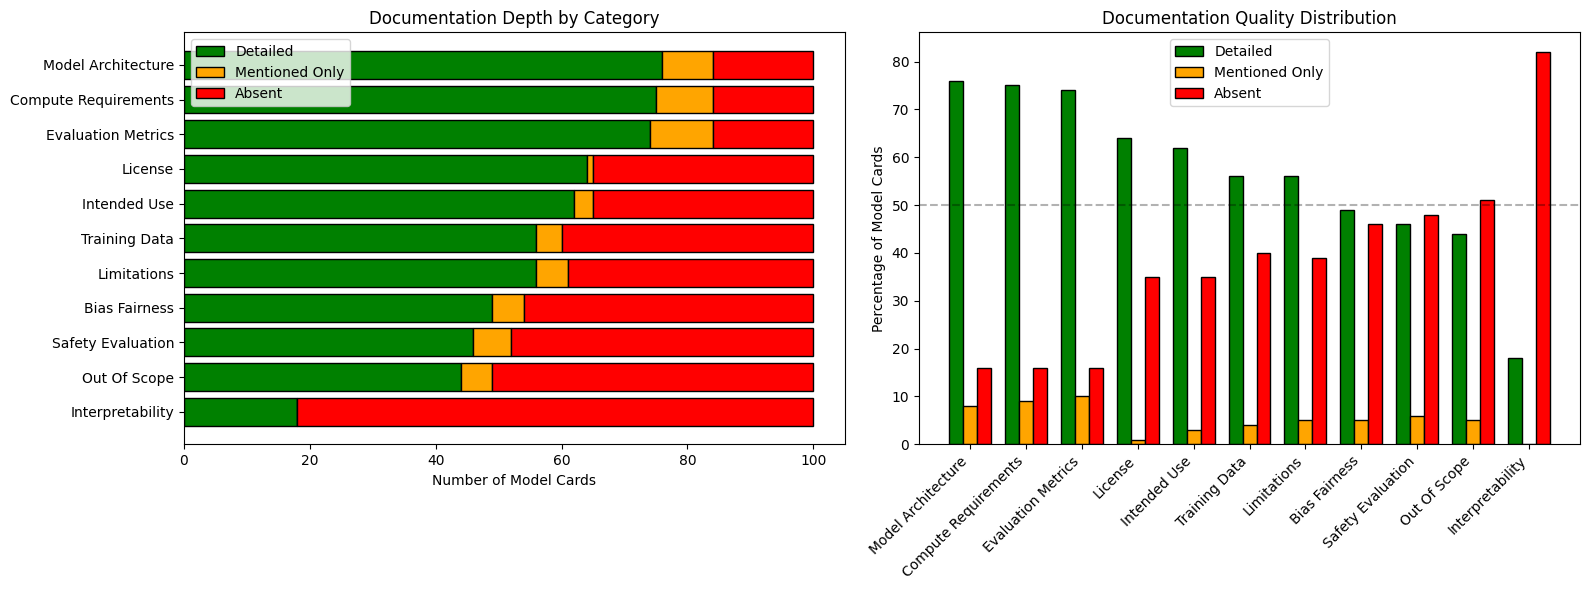


QUALITY SCORE COMPARISON (detailed documentation weighted higher)
Mean quality score: 58.9%
Mean completeness score (previous): 61.5%
Difference: 2.5 percentage points

Top 5 models by QUALITY score (detailed documentation):
  meta-llama/Meta-Llama-3-8B                                   | Quality: 100.0% | Completeness: 100.0%
  meta-llama/Llama-3.1-8B-Instruct                             | Quality: 100.0% | Completeness: 100.0%
  meta-llama/Meta-Llama-3-8B-Instruct                          | Quality: 100.0% | Completeness: 100.0%
  google/gemma-7b                                              | Quality: 100.0% | Completeness: 100.0%
  meta-llama/Llama-3.3-70B-Instruct                            | Quality: 100.0% | Completeness: 100.0%


In [22]:
# Create depth comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data for stacked bar chart
categories = list(critical_info_categories.keys())
detailed_counts = [(df_depth[cat] == 'detailed').sum() for cat in categories]
mentioned_counts = [(df_depth[cat] == 'mentioned').sum() for cat in categories]
absent_counts = [(df_depth[cat] == 'absent').sum() for cat in categories]

# Sort by detailed percentage
sorted_indices = sorted(range(len(detailed_counts)), key=lambda i: detailed_counts[i], reverse=True)
categories_sorted = [categories[i].replace('_', ' ').title() for i in sorted_indices]
detailed_sorted = [detailed_counts[i] for i in sorted_indices]
mentioned_sorted = [mentioned_counts[i] for i in sorted_indices]
absent_sorted = [absent_counts[i] for i in sorted_indices]

# 1. Stacked bar chart
y_pos = range(len(categories_sorted))
axes[0].barh(y_pos, detailed_sorted, label='Detailed', color='green', edgecolor='black')
axes[0].barh(y_pos, mentioned_sorted, left=detailed_sorted, label='Mentioned Only', color='orange', edgecolor='black')
axes[0].barh(y_pos, absent_sorted, left=[d+m for d,m in zip(detailed_sorted, mentioned_sorted)], 
             label='Absent', color='red', edgecolor='black')

axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(categories_sorted)
axes[0].set_xlabel('Number of Model Cards')
axes[0].set_title('Documentation Depth by Category')
axes[0].legend()
axes[0].invert_yaxis()

# 2. Detailed vs mentioned vs absent percentages
detailed_pct = [d/100*100 for d in detailed_sorted]
mentioned_pct = [m/100*100 for m in mentioned_sorted]
absent_pct = [a/100*100 for a in absent_sorted]

x = range(len(categories_sorted))
width = 0.25

axes[1].bar([i-width for i in x], detailed_pct, width, label='Detailed', color='green', edgecolor='black')
axes[1].bar(x, mentioned_pct, width, label='Mentioned Only', color='orange', edgecolor='black')
axes[1].bar([i+width for i in x], absent_pct, width, label='Absent', color='red', edgecolor='black')

axes[1].set_xticks(x)
axes[1].set_xticklabels(categories_sorted, rotation=45, ha='right')
axes[1].set_ylabel('Percentage of Model Cards')
axes[1].set_title('Documentation Quality Distribution')
axes[1].legend()
axes[1].axhline(50, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('documentation_depth_analysis.png', dpi=300, bbox_inches='tight')
print("Saved visualization as 'documentation_depth_analysis.png'\n")
plt.show()

# Calculate a better "quality score" based on depth
df_info['quality_score'] = df_depth[list(critical_info_categories.keys())].apply(
    lambda row: sum(1 if v == 'detailed' else 0.5 if v == 'mentioned' else 0 for v in row), axis=1
) / len(critical_info_categories) * 100

print("\n" + "="*80)
print("QUALITY SCORE COMPARISON (detailed documentation weighted higher)")
print("="*80)
print(f"Mean quality score: {df_info['quality_score'].mean():.1f}%")
print(f"Mean completeness score (previous): {df_info['completeness_score'].mean():.1f}%")
print(f"Difference: {df_info['completeness_score'].mean() - df_info['quality_score'].mean():.1f} percentage points\n")

print("Top 5 models by QUALITY score (detailed documentation):")
top5_quality = df_info.nlargest(5, 'quality_score')[['model_id', 'quality_score', 'completeness_score']]
for idx, row in top5_quality.iterrows():
    print(f"  {row['model_id']:<60} | Quality: {row['quality_score']:.1f}% | Completeness: {row['completeness_score']:.1f}%")